# Rideshare Options Around A Location

---
Azure Maps Mobility service (http://bit.ly/332vWZv) allows functionality for public transit, bike share, and scooter share routing with multimodal trip planning options. For public transit, the service offers search for nearby stations, stops, and lines and provides information like scheduled and real-time public transit arrivals, list of stops and route guides, as well as detailed and multimodal step-by-step itineraries and service alerts. The mobility service also returns real-time and static availability information to car share vehicles and shared bikes and scooters. 

I have included a few scenarios in this walkthrough:

1. Geocoding to find the lat long for any address
2. Finding the MetroID for use in the Mobility API for the address you are analyzing
3. Using the Find Nearby Transit Options API

For Geocoding, Azure Maps does not have the same level of information and accuracy for all cities and countries/regions. Check this table to see if your region is covered: http://bit.ly/2LHMiAV


---

In [3]:
import os
import json
import time
import requests
import urllib.parse
from IPython.display import Image, display

Load Subscription Key for Azure Maps from Config File. If you dont have an Azure Maps Subscription Key, get yourself a free account here: http://bit.ly/2VV39SG

In [4]:
config_file = 'config.json'
key = json.load(open(config_file))['key']
subscriptionKey = key

The Azure Maps Search Service provides the ability for customers to find real world objects and their respective location. The Search Service provides for three major functions:
    1. Geocoding: Finding addresses, places, and landmarks
    2. Point of Interest (POI) Search: Finding businesses based on a location
    3. Reverse Geocoding: Finding addresses or cross streets based on a location
    
You can customize this for the address that you want analyze by replacing the address below:

In [21]:
addresstoAnalyze = "15563 NE 31st St, Redmond, WA 98052"
locationDetails = requests.get("https://atlas.microsoft.com/search/address/json?subscription-key={}&api-version=1.0&query={}".format(subscriptionKey,addresstoAnalyze)).json()
latlong=locationDetails["results"][0]["position"]
objectT = "docklessElectricScooter"
currentLocation=[0,0]
currentLocation[0]=latlong["lat"]
currentLocation[1]=latlong["lon"]

The *Get Metro Area* API allows to request metro areas in which the Azure Maps Mobility Service is available. The service supports filtering results by country or coordinate location. Information returned includes Metro Area details such as metro Id, name and a representation of the metro area geometry in GeoJSON format.

In [22]:
metroAreaID = requests.get("https://atlas.microsoft.com/mobility/metroArea/id/json?subscription-key={}&api-version=1.0&queryType=position&query={}".format(subscriptionKey,str(currentLocation[0])+","+str(currentLocation[1]))).json()
metroID1 = metroAreaID["results"][0]["metroId"]
metroName1 = metroAreaID["results"][0]["metroName"]
print("The Metro ID for", metroName1, "is",metroID1)

The Metro ID for Seattle–Tacoma–Bellevue, WA is 522


The Get Nearby Transit service (http://bit.ly/31Ui6Iw) allows you to search transit objects, for example, public transit stops and shared bikes around a given location returning the transit object details. The Service allows users to search for specific object types and within a given radius returning a set of transit object with object details.

In [23]:
transitOptions = requests.get("https://atlas.microsoft.com/mobility/transit/nearby/json?subscription-key={}&api-version=1.0&metroId={}&query={}&radius=1000&objectType={}".format(subscriptionKey,metroID1,str(currentLocation[0])+","+str(currentLocation[1]),objectT)).json()

This is the returned json from the Get Nearby Transit Service with the details of the nearby stops

In [24]:
transitOptionsF = json.dumps(transitOptions, indent=4)
print(transitOptionsF)

{
    "results": [
        {
            "id": "522---DLV%3A2372%23VRE_47_",
            "type": "docklessElectricScooter",
            "objectDetails": {
                "operatorInfo": {
                    "id": "522---2372",
                    "name": "Lime"
                }
            },
            "position": {
                "latitude": 47.637156,
                "longitude": -122.133531
            },
            "viewport": {
                "topLeftPoint": {
                    "latitude": 47.638065,
                    "longitude": -122.134847
                },
                "btmRightPoint": {
                    "latitude": 47.636246,
                    "longitude": -122.132214
                }
            }
        },
        {
            "id": "522---DLV%3A2372%23NEQ_47_",
            "type": "docklessElectricScooter",
            "objectDetails": {
                "operatorInfo": {
                    "id": "522---2372",
                    "name": "Lime"
    

In [25]:
print("There are "+ str(len(transitOptions["results"])) +" Dockless Electric Scooters available near "+ addresstoAnalyze +":")


There are 3 Dockless Electric Scooters available near 15563 NE 31st St, Redmond, WA 98052:


In [26]:
for loc in range(len(transitOptions["results"])):
    print("\n",loc+1,". ","Operator: ", transitOptions["results"][loc]["objectDetails"]["operatorInfo"]["name"])
    


 1 .  Operator:  Lime

 2 .  Operator:  Lime

 3 .  Operator:  Lime


In [27]:
url = "https://atlas.microsoft.com/map/static/png"
payload = ""
centerMap = str(currentLocation[1])+","+str(currentLocation[0])
circlePath = "ra600||" + str(currentLocation[1])+" "+str(currentLocation[0])

In [28]:
stopLocations = []
for loc in range(len(transitOptions["results"])):
                location = list(transitOptions["results"][loc]["position"].values())
                location[0], location[1] = location[1], location[0]
                stopLocations.append(location)

In [29]:
stopData = {
    "type": "FeatureCollection",
    "features": [
      {
        "type": "Feature",
        "properties": {},
        "geometry": {
            "type": "MultiPoint",
            "coordinates": stopLocations
        }
    }
  ]
}

In [30]:
uploadstopsResponse = requests.post(url = "https://atlas.microsoft.com/mapData/upload?subscription-key={}&api-version=1.0&dataFormat=geojson".format(subscriptionKey), json = stopData)

stopsUdidRequest = uploadstopsResponse.headers["Location"]+"&subscription-key="+subscriptionKey

while True:
    getstopsUdid = requests.get(stopsUdidRequest).json()
    if 'udid' in getstopsUdid:
        break
    else:
        time.sleep(0.2)
stopsUdid = getstopsUdid["udid"]

In [31]:
pinsList = "default|an15 53||udid-{}".format(stopsUdid)

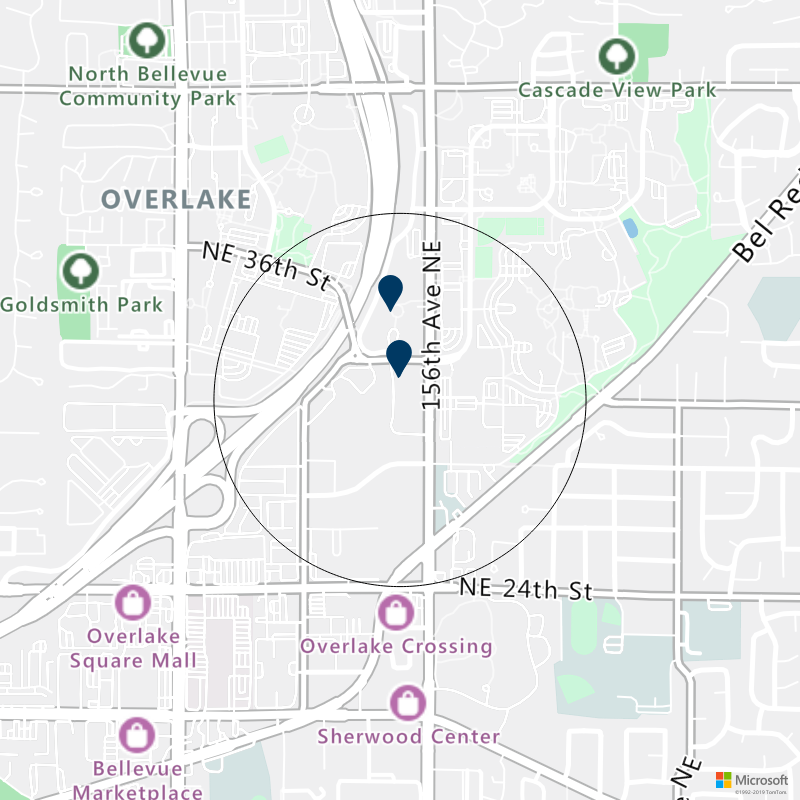

In [32]:
querystring = {
        "api-version":"1.0",
        "subscription-key":key,
        "format":"png",
        "layer":"basic",
        "zoom":"14",
        "center":centerMap,
        "height":"800",
        "width":"800",
        "pins":pinsList,
        "path":circlePath
    }
headers = {
    'cache-control': "no-cache"
    }

r = requests.get(url,data=payload, headers=headers, params=querystring, stream=all)

display(Image(r.content))